# Практический кейс

ФИО слушателя: Прокопьева Елена Георгиевна

Тема: Прогнозирование размеров сварного шва при электронно-лучевой сварке
тонкостенных конструкций аэрокосмического назначения

Исходные данные: результаты экспериментальных исследований на установке электронно-лучевой сварки на образцах-имитаторах, соответствующих технологическому изделию.

IW - величина сварочного тока
IF - ток фокусировки электронного пучка
VW - скорость сварки
FP - расстояние от поверхности образцов до электронно-оптической системы
Depth - глубина шва
Width - ширина шва

Задача: решить задачу регрессии (одним или несколькими методами)
для предсказания глубины и ширины сварного соединения, выполнив
необходимые этапы (разведочный анализ, предобработка)

## Блок импорта библиотек

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [5]:
import pickle

## Подгрузка датасета

In [6]:
#Считывается csv-файл
WLD = pd.read_csv("./data/ebw_data.csv")

## Разведочный анализ данных

In [7]:
# Информация по датасету - количество строк, наименования столбцов, типы данных
WLD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


В наборе данных присутствуют только числовые данные типа int и float.
Категориальные признаки отсутствуют.
Всего 72 строки и 6 столбцов

In [8]:
# Отображение шапки датафрейма и первых 5 строк с данными
WLD.head()

IW   IF   VW  FP  Depth  Width
0  47  139  4.5  80   1.60   2.54
1  47  139  4.5  80   1.62   2.50
2  47  139  4.5  80   1.68   2.60
3  47  139  4.5  80   1.58   2.52
4  45  140  4.5  80   1.76   2.48

In [9]:
# Шапка и 10 случайных строк
WLD.sample(10)

IW   IF    VW   FP  Depth  Width
54  43  150   9.0   50   1.08   1.82
41  47  140  10.0   80   1.22   1.82
27  47  134  10.0  110   0.94   1.94
5   45  140   4.5   80   1.72   2.48
34  48  131  10.0  125   0.88   2.00
44  46  146  10.0   60   1.28   1.80
67  44  146   9.0   60   1.20   1.72
45  46  146  10.0   60   1.36   1.76
11  45  140   8.0   80   1.20   1.96
58  44  146   9.0   60   1.20   1.88

In [10]:
# Размерность датасета
WLD.shape

(72, 6)

In [11]:
# Проверка данных на пропуски
WLD.isna().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

Датасет характеризуется небольшим набором данных, но без пропусков (нет необходимости применения методов заполнения пропущенных значений)

In [12]:
# Описательная статистика (транспонированный вид)
WLD.describe(include='all').applymap('{:,.2f}'.format).T

count    mean    std     min     25%     50%     75%     max
IW     72.00   45.67   1.68   43.00   44.00   45.50   47.00   49.00
IF     72.00  141.33   5.15  131.00  139.00  141.00  146.00  150.00
VW     72.00    8.64   2.06    4.50    8.00    9.00   10.00   12.00
FP     72.00   78.33  21.49   50.00   60.00   80.00   80.00  125.00
Depth  72.00    1.20   0.23    0.80    1.08    1.20    1.29    1.76
Width  72.00    1.97   0.28    1.68    1.76    1.84    2.05    2.60

In [13]:
# Поиск количества уникальных значений по каждому параметру
for i in WLD.columns:
    print(i, ':',WLD[i].unique().size)

IW : 7
IF : 8
VW : 5
FP : 5
Depth : 29
Width : 25


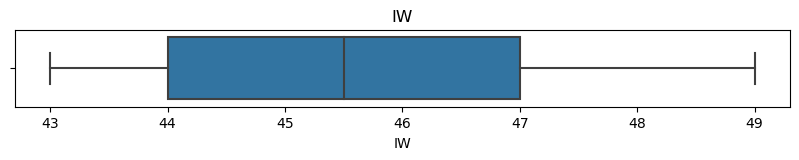

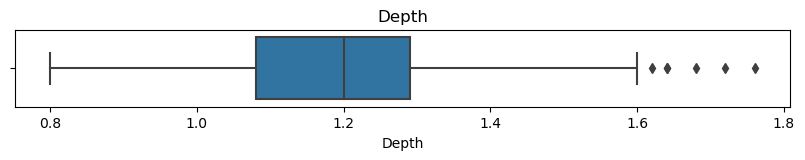

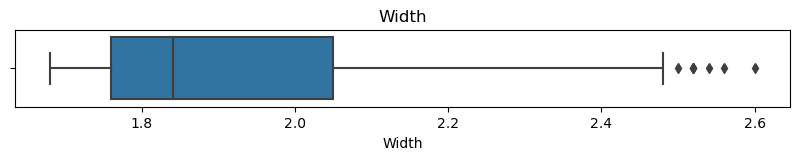

In [14]:
# Проверка визуального распределения данных с применением boxplot
for column in WLD[['IW','IF','VW','FP', 'Depth', 'Width']]:
        plt.figure(figsize = (10,1))
        plt.title(column)
        sns.boxplot(data = WLD, x = column)

Судя по графикам boxplot, в данных имеются выбросы - в показателях VW и FP выбросы единичны, а в Depth и Width уже существенны, учитывая небольшой размер выборки. Причем эти выбросы в области больших значений показателей

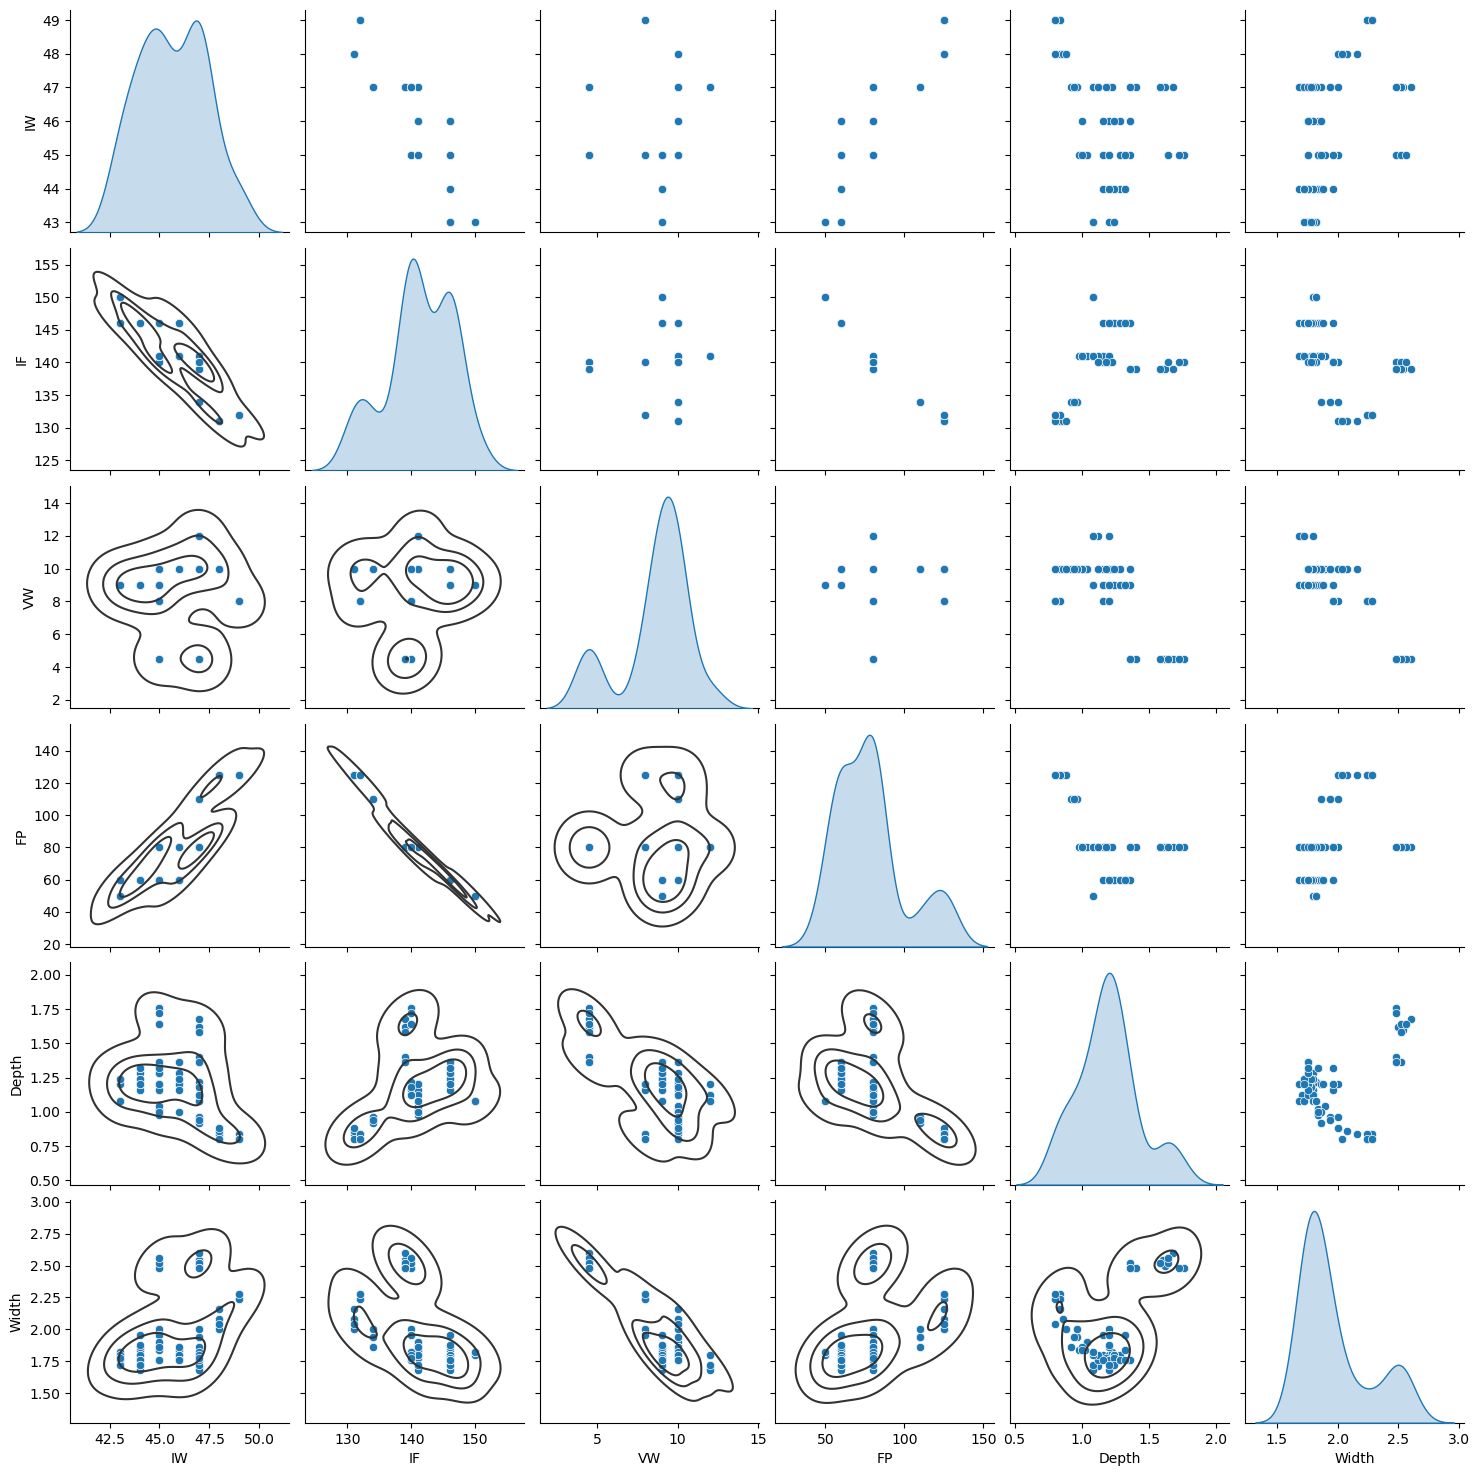

In [15]:
# Построение PairPlot
#sns.pairplot(WLD, diag_kind='kde')
g = sns.pairplot(WLD, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

На глубину шва (Depth) в основном влияют параметр VW (скорость сварки) - чем она выше, тем глубина сварки меньше, и парметр FP (расстояние от поверхности образцов до ЭОС) - чем дальше, тем меньше глубина сварки (ожидаемо).
На ширину шва (Width) в основном влияют параметр VW (скорость сварки) - чем она выше, тем ширина сварки меньше, и парметр IF (ток фокусировки электронного пучка) - чем он выше, тем меньше ширина сварки.

<Axes: >

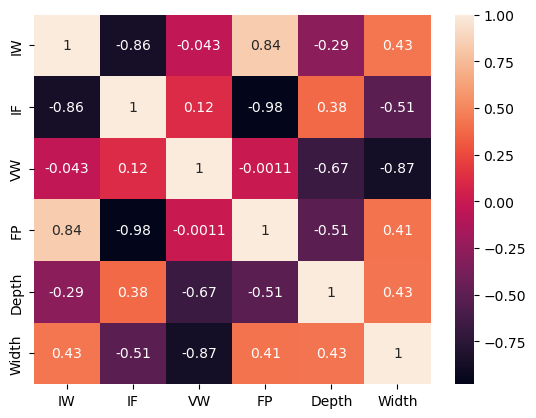

In [16]:
# Тепловая карта с коэффициентами корреляции
sns.heatmap(WLD.corr(numeric_only=True), annot=True)

## Масштабирование

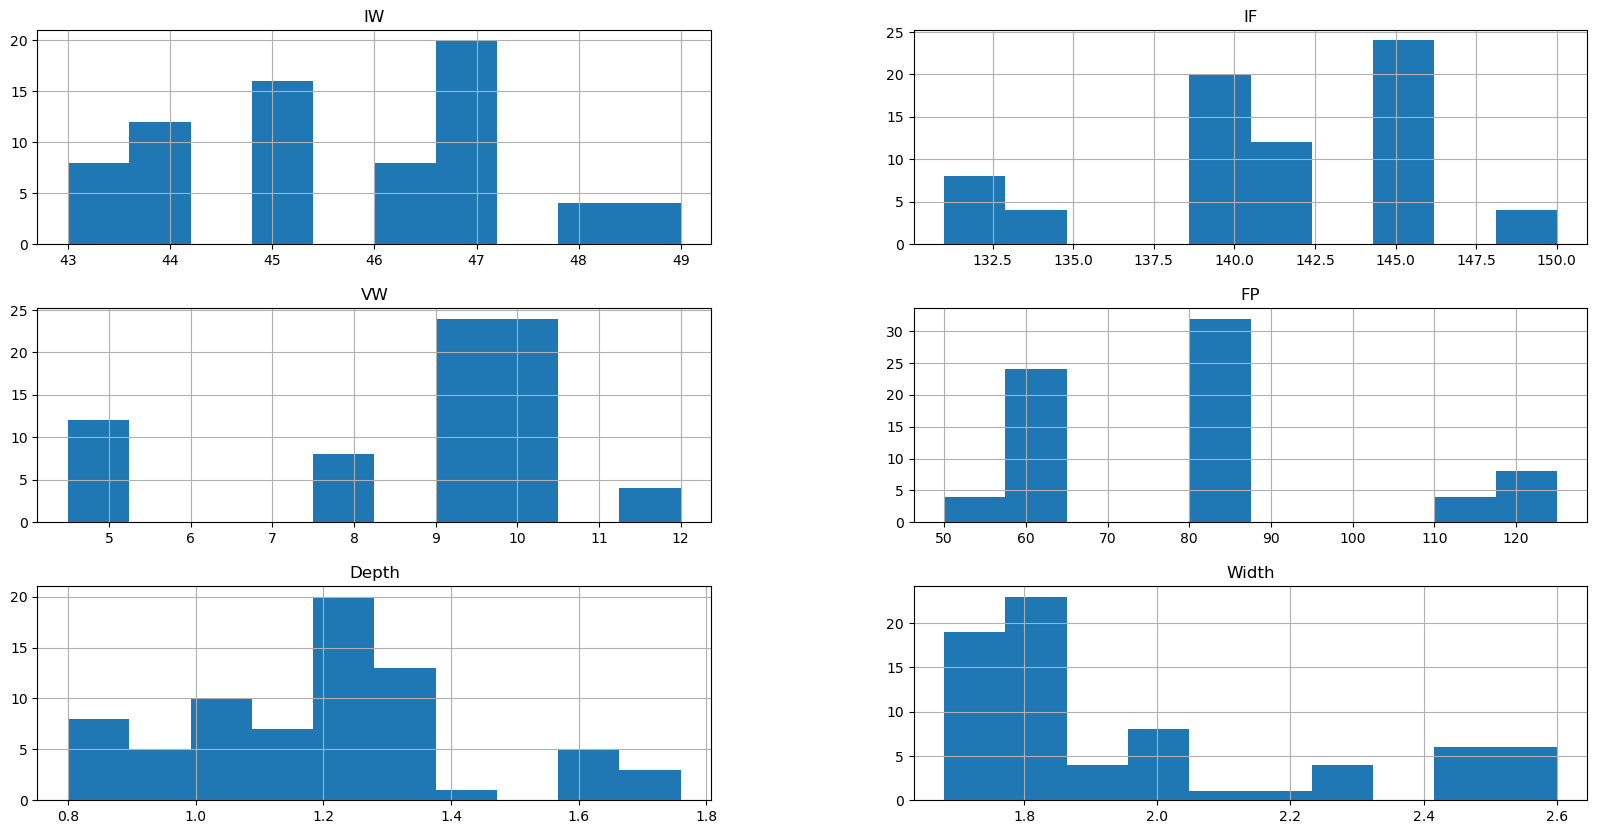

In [17]:
# Гистограммы по каждому параметру
WLD.hist(figsize = (20,10))
plt.show()

Данные находятся в разных диапазонах значений, поэтому можно применить нормализацию, т.е масштабирование от 0 до 1

In [18]:
# Нормализованная версия датасета
WLD_norm = WLD.copy()
scaler = MinMaxScaler()
WLD_norm = pd.DataFrame(scaler.fit_transform(WLD_norm), columns = WLD_norm.columns, index = WLD_norm.index)
WLD_norm.describe()

IW         IF         VW         FP      Depth      Width
count  72.000000  72.000000  72.000000  72.000000  72.000000  72.000000
mean    0.444444   0.543860   0.551852   0.377778   0.412037   0.315670
std     0.279727   0.270830   0.274810   0.286580   0.234460   0.303304
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000
25%     0.166667   0.421053   0.466667   0.133333   0.291667   0.086957
50%     0.416667   0.526316   0.600000   0.400000   0.416667   0.173913
75%     0.666667   0.789474   0.733333   0.400000   0.510417   0.402174
max     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000

# Решение задачи регрессии

In [19]:
# Разделение на входные признаки (X) и выходные показатели (y)
X = WLD[['IW', 'IF', 'VW', 'FP']].values 
y = WLD[['Depth', 'Width']].values 
X.shape, y.shape

((72, 4), (72, 2))

In [20]:
# Разбивка выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((54, 4), (18, 4), (54, 2), (18, 2))

Модель Линейной регрессии

In [21]:
LinearRegressionModel = LinearRegression()
LinearRegressionModel = LinearRegressionModel.fit(X_train, y_train)
y_predLR = LinearRegressionModel.predict(X_test)
print(y_predLR)
print('------------------------')
print(y_test)

[[0.9029501  1.96308301]
 [0.9029501  1.96308301]
 [1.23592549 1.81712196]
 [1.02216873 1.6214525 ]
 [1.63925653 2.49785842]
 [1.23592549 1.81712196]
 [1.49051359 2.44256311]
 [1.23592549 1.81712196]
 [0.7791717  2.04480896]
 [1.27193639 1.84484949]
 [1.23592549 1.81712196]
 [1.63925653 2.49785842]
 [1.63925653 2.49785842]
 [1.22252868 1.85508619]
 [0.7791717  2.04480896]
 [1.1529985  1.75371501]
 [1.27193639 1.84484949]
 [1.19991459 1.78939443]]
------------------------
[[0.92 1.86]
 [0.94 1.94]
 [1.28 1.8 ]
 [1.2  1.8 ]
 [1.4  2.48]
 [1.32 1.96]
 [1.64 2.56]
 [1.2  1.76]
 [0.88 2.  ]
 [1.32 1.76]
 [1.2  1.76]
 [1.36 2.52]
 [1.36 2.48]
 [1.12 1.8 ]
 [0.86 2.08]
 [1.08 1.82]
 [1.28 1.76]
 [1.2  1.72]]


In [22]:
print("MSE: ", mean_squared_error(y_test, y_predLR))
print("MAE: ", mean_absolute_error(y_test, y_predLR))
print("R^2: ", r2_score(y_test, y_predLR))

MSE:  0.011956481066115174
MAE:  0.08298057852828244
R^2:  0.7408088539289372


In [23]:
y_predLR = pd.DataFrame({
    'Model': 'LinearRegression',
    'MSE': mean_squared_error(y_test, y_predLR),
    'MAE': mean_absolute_error(y_test, y_predLR),
    'R^2': r2_score(y_test, y_predLR)
   }, index=['DTR'])

In [24]:
MetricsTable = pd.DataFrame()
MetricsTable = pd.concat([MetricsTable, y_predLR])
MetricsTable

Model       MSE       MAE       R^2
DTR  LinearRegression  0.011956  0.082981  0.740809

Модель Деревья Решений

In [25]:
DecisionTreeModel = DecisionTreeRegressor()
DecisionTreeModel = DecisionTreeModel.fit(X_train, y_train)
y_predDT = DecisionTreeModel.predict(X_test)
print(y_predDT)
print('------------------------')
print(y_test)

[[0.96       1.97      ]
 [0.96       1.97      ]
 [1.22       1.7825    ]
 [1.09333333 1.70333333]
 [1.568      2.528     ]
 [1.22       1.7825    ]
 [1.70666667 2.49333333]
 [1.22       1.7825    ]
 [0.82       2.1       ]
 [1.32       1.76      ]
 [1.22       1.7825    ]
 [1.568      2.528     ]
 [1.568      2.528     ]
 [1.17333333 1.78666667]
 [0.82       2.1       ]
 [1.08       1.81333333]
 [1.32       1.76      ]
 [1.22666667 1.78      ]]
------------------------
[[0.92 1.86]
 [0.94 1.94]
 [1.28 1.8 ]
 [1.2  1.8 ]
 [1.4  2.48]
 [1.32 1.96]
 [1.64 2.56]
 [1.2  1.76]
 [0.88 2.  ]
 [1.32 1.76]
 [1.2  1.76]
 [1.36 2.52]
 [1.36 2.48]
 [1.12 1.8 ]
 [0.86 2.08]
 [1.08 1.82]
 [1.28 1.76]
 [1.2  1.72]]


In [26]:
print("MSE: ", mean_squared_error(y_test, y_predDT))
print("MAE: ", mean_absolute_error(y_test, y_predDT))
print("R^2: ", r2_score(y_test, y_predDT))

MSE:  0.0065510524691358
MAE:  0.0579074074074074
R^2:  0.8638233227848102


In [27]:
y_predDT = pd.DataFrame({
    'Model': 'DecisionTreeRegressor',
    'MSE': mean_squared_error(y_test, y_predDT),
    'MAE': mean_absolute_error(y_test, y_predDT),
    'R^2': r2_score(y_test, y_predDT)
   }, index=['DTR'])

Модель Случайного Леса

In [28]:
MetricsTable = pd.concat([MetricsTable, y_predDT])
MetricsTable

Model       MSE       MAE       R^2
DTR       LinearRegression  0.011956  0.082981  0.740809
DTR  DecisionTreeRegressor  0.006551  0.057907  0.863823

In [32]:
RandomForestModel = RandomForestRegressor()
RandomForestModel = RandomForestModel.fit(X_train, y_train)
y_predRF = RandomForestModel.predict(X_test)
print(y_predRF)
print('------------------------')
print(y_test)

[[0.95153143 1.98840095]
 [0.95153143 1.98840095]
 [1.21966811 1.78270161]
 [1.09679238 1.70705905]
 [1.57481069 2.53114216]
 [1.21966811 1.78270161]
 [1.6972981  2.49441714]
 [1.21966811 1.78270161]
 [0.82554857 2.10351238]
 [1.30533482 1.76300195]
 [1.21966811 1.78270161]
 [1.57481069 2.53114216]
 [1.57481069 2.53114216]
 [1.17323667 1.79169048]
 [0.82554857 2.10351238]
 [1.08443333 1.81207405]
 [1.30533482 1.76300195]
 [1.22320424 1.78018939]]
------------------------
[[0.92 1.86]
 [0.94 1.94]
 [1.28 1.8 ]
 [1.2  1.8 ]
 [1.4  2.48]
 [1.32 1.96]
 [1.64 2.56]
 [1.2  1.76]
 [0.88 2.  ]
 [1.32 1.76]
 [1.2  1.76]
 [1.36 2.52]
 [1.36 2.48]
 [1.12 1.8 ]
 [0.86 2.08]
 [1.08 1.82]
 [1.28 1.76]
 [1.2  1.72]]


In [33]:
print("MSE: ", mean_squared_error(y_test, y_predRF))
print("MAE: ", mean_absolute_error(y_test, y_predRF))
print("R^2: ", r2_score(y_test, y_predRF))

MSE:  0.006825499748905809
MAE:  0.05877731842231819
R^2:  0.8593009902487002


In [34]:
y_predRF = pd.DataFrame({
    'Model': 'RandomForestRegressor',
    'MSE': mean_squared_error(y_test, y_predRF),
    'MAE': mean_absolute_error(y_test, y_predRF),
    'R^2': r2_score(y_test, y_predRF)
   }, index=['DTR'])

In [35]:
MetricsTable = pd.concat([MetricsTable, y_predRF])
MetricsTable

Model       MSE       MAE       R^2
DTR       LinearRegression  0.011956  0.082981  0.740809
DTR  DecisionTreeRegressor  0.006551  0.057907  0.863823
DTR  RandomForestRegressor  0.006825  0.058777  0.859301

Было применено три модели машинного обучения - Линейная регрессия, Деревья решений и Случайный лес

Наилучшими параметрами характеризуются модели Дерева решений и Случайного леса по всем трем метрикам MSE, MAE и R^2

In [41]:
!pip freeze

absl-py==2.0.0
aiobotocore @ file:///C:/b/abs_74o47svlua/croot/aiobotocore_1680004300264/work
aiofiles @ file:///C:/b/abs_9ex6mi6b56/croot/aiofiles_1683773603390/work
aiohttp @ file:///C:/ci_311/aiohttp_1676432932774/work
aioitertools @ file:///tmp/build/80754af9/aioitertools_1607109665762/work
aiosignal @ file:///tmp/build/80754af9/aiosignal_1637843061372/work
aiosqlite @ file:///C:/b/abs_9djc_0pyi3/croot/aiosqlite_1683773915844/work
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-anon-usage @ file:///C:/b/abs_f4tsjyl9va/croot/anaconda-anon-usage_1695310457827/work
anaconda-catalogs @ file:///C:/b/abs_8btyy0o8s8/croot/anaconda-catalogs_1685727315626/work
anaconda-client==1.12.0
anaconda-cloud-auth @ file:///C:/b/abs_5cjpnu6wjb/croot/anaconda-cloud-auth_1694462130037/work
anaconda-navigator @ file:///C:/b/abs_ab00e0_u7e/croot/anaconda-navigator_1695238210954/work
anaconda-project @ file:///C:/ci_311/anaconda-project_1676458365912/work
anyio @ file:///C:/ci_

In [49]:
params = X_test[0]
params

array([ 47., 134.,  10., 110.])

In [48]:
params.shape

(18, 4)

In [51]:
params.reshape((1,4))

array([[ 47., 134.,  10., 110.]])

In [53]:
appmodel = RandomForestModel

In [54]:
params_pred = appmodel.predict(params.reshape((1,4)))

In [55]:
params_pred

array([[0.95153143, 1.98840095]])

In [56]:
params_pred.shape

(1, 2)

In [62]:
appmodel.predict([[2., 3., 10., 2.]])

array([[1.01411281, 1.93979416]])

## Сохранение модели

In [66]:
pickle_out = open(r'B:\Учебные материалы\Final_assessment\app\models\RandomForestModel.pkl', 'wb')
pickle.dump(RandomForestModel,pickle_out)
pickle_out.close()
#pickle.dump(RandomForestModel, open(r'B:\Учебные материалы\Final_assessment\app\models\RandomForestModel.pkl', 'wb'))

In [64]:
model_loaded = pickle.load(open(r'B:\Учебные материалы\Final_assessment\app\models\RandomForestModel.pkl', 'rb'))

In [65]:
model_loaded.predict(X_test)

array([[0.95153143, 1.98840095],
       [0.95153143, 1.98840095],
       [1.21966811, 1.78270161],
       [1.09679238, 1.70705905],
       [1.57481069, 2.53114216],
       [1.21966811, 1.78270161],
       [1.6972981 , 2.49441714],
       [1.21966811, 1.78270161],
       [0.82554857, 2.10351238],
       [1.30533482, 1.76300195],
       [1.21966811, 1.78270161],
       [1.57481069, 2.53114216],
       [1.57481069, 2.53114216],
       [1.17323667, 1.79169048],
       [0.82554857, 2.10351238],
       [1.08443333, 1.81207405],
       [1.30533482, 1.76300195],
       [1.22320424, 1.78018939]])

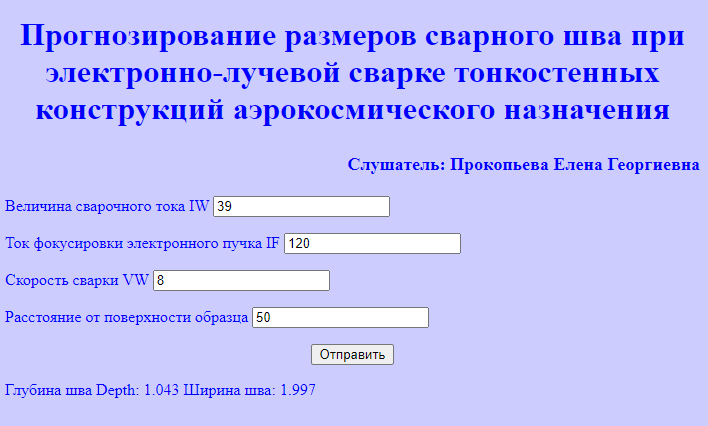

In [68]:
from IPython import display
# Скрин приложения
display.Image("B:\Учебные материалы\Final_assessment\Final_ProkopevaEG\Local_app1.PNG")

В пустые поля необходимо вносить входные параметры (величина сварочного тока, ток фокусировки электронного пучка, скорость сварки и расстояние от поверхности образца). Далее нажать кпопку "Отправить". Результатам будет расчет глубины и ширины сварочного шва.